In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import mglearn
import warnings

warnings.filterwarnings('ignore') 
plt.style.use('classic')

In [2]:
# 일반적인 모델
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SVC().fit(X_train_scaled, y_train)

print(f"test score: {svm.score(X_test_scaled, y_test):0.3f}")

test score: 0.972


In [3]:
# 일반적인 더 좋은 매개변수 찾기
from sklearn.model_selection import GridSearchCV

param_grid = {'C' : [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma' : [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

print(f"최상의 교차 검증 정확도 : {grid.best_score_:0.3f}")
print(f"테스트 점수 : {grid.score(X_test_scaled, y_test):0.3f}")
print("최적의 매개변수 : ", grid.best_params_)

최상의 교차 검증 정확도 : 0.981
테스트 점수 : 0.972
최적의 매개변수 :  {'C': 1, 'gamma': 1}


## 교차 검증을 사용할 경우 발생할 수 있는 오류
### train, test 셋을 구분하고 scaler는 train 셋에만 종속되어 있어 test 셋을 독립적인 환경에서 평가할 수 있었다.
### 하지만 교차 검증을 하면서 train, test 셋이 다시 섞이게 되고 그 결과 test셋은 독립적인 환경에서 평가할 수 없게 된다.

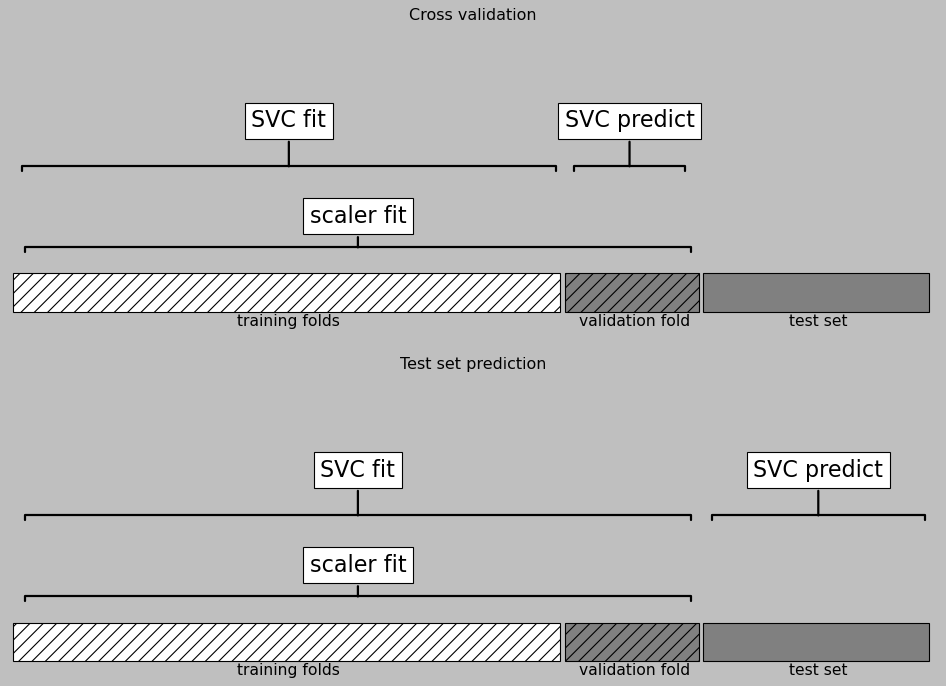

In [4]:
mglearn.plots.plot_improper_processing()

## 해결법
### 이를 해결하기 위해서는 scaler에서 fit 하는 과정이 교차검증의 모든 과정에 각각 포함되어야 한다.
### sklearn 에서는 이를 pipeline을 통해 구현할 수 있다.

In [5]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])
pipe.fit(X_train, y_train)

print(f"test score : {pipe.score(X_test, y_test):0.3f}")

test score : 0.972


# 그리드 서치에 파이프 라인 적용하기

In [6]:
# "(파이프라인에 지정한 이름)__(매개변수명)"
param_grid = {"svm__C" : [0.001, 0.01, 0.1, 1, 10, 100], 
              "svm__gamma" : [0.001, 0.01, 0.1, 1, 10, 100]}

In [7]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print(f"최상의 교차 검증 정확도 : {grid.best_score_:0.3f}")
print(f"테스트 점수 : {grid.score(X_test, y_test):0.3f}")
print("최적의 매개변수 : ", grid.best_params_)

최상의 교차 검증 정확도 : 0.981
테스트 점수 : 0.972
최적의 매개변수 :  {'svm__C': 1, 'svm__gamma': 1}


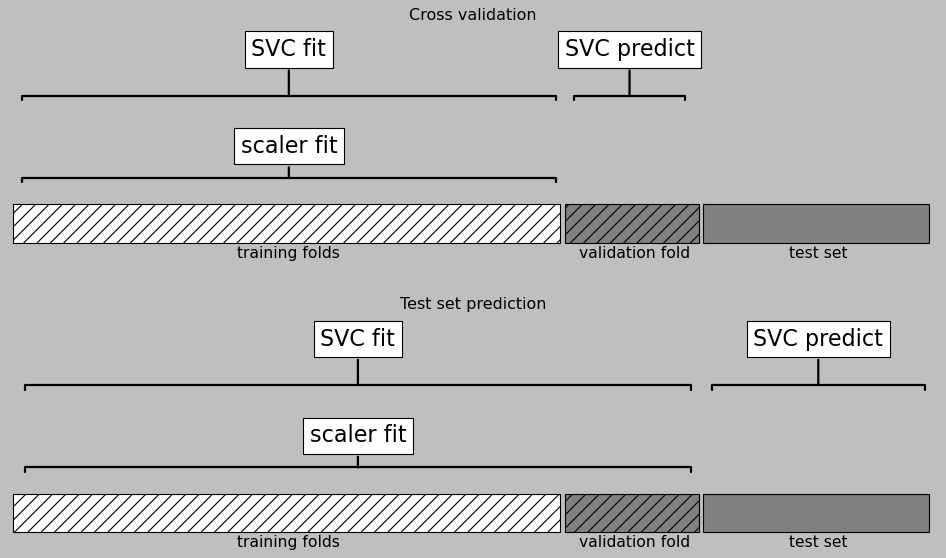

In [8]:
mglearn.plots.plot_proper_processing()

# 파이프라인 인터페이스
### 마지막 단계를 제외하고 fit, transform 메서드가 있어야 한다.
### 마지막 단계는 fit만 있으면 된다.

In [9]:
# 이름을 짓지 않고 파이프라인을 만들 수 도 있다.
from sklearn.pipeline import make_pipeline
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))
print("파이프라이 단계:\n", pipe_short.steps)

파이프라이 단계:
 [('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("파이프라이 단계:\n", pipe.steps)

# 파이프라인의 특정 단계에 접근하기
pipe.fit(cancer.data)
components = pipe.named_steps['pca'].components_
print("components.shape : ", components.shape)

파이프라이 단계:
 [('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]
components.shape :  (2, 30)


In [11]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
print("파이프라이 단계:\n", pipe.steps)

파이프라이 단계:
 [('standardscaler', StandardScaler()), ('logisticregression', LogisticRegression(max_iter=1000))]


In [12]:
param_grid = {"logisticregression__C" : [0.01, 0.1, 1, 10, 100]}
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [13]:
print("최상의 모델 : \n", grid.best_estimator_)

최상의 모델 : 
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1, max_iter=1000))])


In [14]:
# 최상의 파이프라인의 개별 속성에 접근하기
print("로지스틱 회귀 단계:\n", grid.best_estimator_.named_steps['logisticregression'])

로지스틱 회귀 단계:
 LogisticRegression(C=1, max_iter=1000)


In [15]:
print("로지스틱 회귀 계수:\n", grid.best_estimator_.named_steps['logisticregression'].coef_)

로지스틱 회귀 계수:
 [[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


# 전처리와 모델의 매개변수를 위한 그리드 서치

In [16]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge(),
)

In [19]:
param_grid = {'polynomialfeatures__degree' : [1,2,3],
              'ridge__alpha' : [0.001,0.01,0.1,1,10,100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

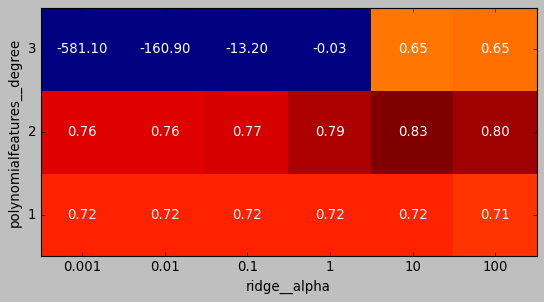

In [22]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3,-1),
                      xlabel='ridge__alpha', ylabel='polynomialfeatures__degree',
                      xticklabels=param_grid['ridge__alpha'],
                      yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)

In [23]:
print("최적의 매개변수 : ", grid.best_params_)

최적의 매개변수 :  {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [24]:
print(f"테스트 점수 : {grid.score(X_test, y_test):0.3f}")

테스트 점수 : 0.768


In [26]:
param_grid = {'ridge__alpha':[0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print(f"다항 특성이 없을 때 점수 : {grid.score(X_test, y_test):0.3f}")

다항 특성이 없을 때 점수 : 0.627


In [27]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [46]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier' : [SVC()], 'preprocessing':[StandardScaler()],
     'classifier__gamma':[0.001,0.01,0.1,1,10,100],
     'classifier__C':[0.001,0.01,0.1,1,10,100]},
    {'classifier':[RandomForestClassifier(n_estimators=100)],
     'preprocessing':[None], 'classifier__max_features':[1,2,3]}
]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("최적의 매개변수 :", grid.best_params_)
print(f"최상의 교차검증 점수 : {grid.best_score_:0.3f}")
print(f"테스트 세트 점수 : {grid.score(X_test, y_test):0.3f}")

최적의 매개변수 : {'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}
최상의 교차검증 점수 : 0.986
테스트 세트 점수 : 0.979
